In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb
!pip install gensim
!pip install tensorflow-addons

In [5]:
import pandas as pd
import re
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
import seaborn as sns
import string
import nltk
import numpy as np
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, DataCollatorWithPadding, Trainer, TrainingArguments
from datasets import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from tqdm import tqdm
import io
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa
import gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


# COVID Tweets Dataset
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

In [22]:
vid_train = pd.read_csv('/content/gdrive/My Drive/Магистериум/NLP/Corona_NLP_train.csv', encoding='latin1')
vid_test = pd.read_csv('/content/gdrive/My Drive/Магистериум/NLP/Corona_NLP_test.csv', encoding='latin1')

In [23]:
vid_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Использованный датасет служит для решения задачи сентимент-анализа на базе твитов про covid. Задача определяется как мультиклассовая к 5 классами:

In [24]:
print('Classes:')
print('___________________')
for i in vid_train['Sentiment'].unique():
    print(i)

Classes:
___________________
Neutral
Positive
Extremely Negative
Negative
Extremely Positive


Классы "Extremely Negative" и "Extremely Positive" могут быть потенциально сведены к "Negative" и "Positive", так как обычно в задачах сентимент-анализа такие крайние классы мало отличаются от классов с менее выраженным отношением, позитивным или негативным.

In [25]:
print(f'Число примеров в обучающей выборке: {vid_train.shape[0]}')
print(f'Число примеров в тестовой выборке: {vid_test.shape[0]}')

Число примеров в обучающей выборке: 41157
Число примеров в тестовой выборке: 3798


## EDA

Рассмотрим для начала распределение классов. В тренировочном корпусе сравнительно мала доля сильно позитивного и сильно негативного классов. В целом, больше представлены позитивные тексты (Positive + Extremely Positive ~ 44%, 37% - негативные)

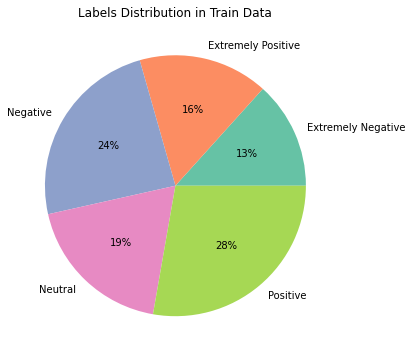

In [26]:
plt.figure(figsize=(8, 6))
data = list(vid_train.groupby('Sentiment').count()['OriginalTweet'])
names = vid_train.groupby('Sentiment').count()['OriginalTweet'].index

palette_color = sns.color_palette('Set2')
plt.pie(data, labels=names, colors=palette_color, autopct='%.0f%%')
plt.title('Labels Distribution in Train Data', loc='center')
plt.show()

Также и в тестовом мало представлены классы с сильной семантикой (Extremely Positive|Negative), то же касается и нейтрального класса.

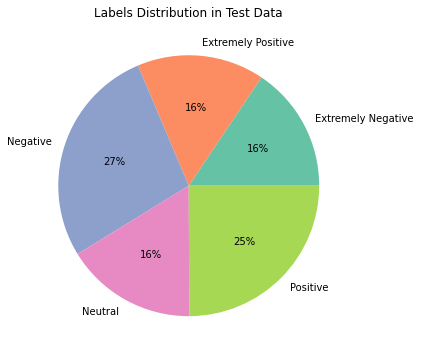

In [27]:
plt.figure(figsize=(8, 6))
data = list(vid_test.groupby('Sentiment').count()['OriginalTweet'])
names = vid_test.groupby('Sentiment').count()['OriginalTweet'].index
  
palette_color = sns.color_palette('Set2')

plt.pie(data, labels=names, colors=palette_color, autopct='%.0f%%')
plt.title('Labels Distribution in Test Data', loc='center')
plt.show()

В датасете также встречается много хэштегов, причем общей тематики, не являющихся показателями отношения к теме.

In [28]:
def get_hashtags(tweet):
    tags = re.findall(r'#\w+',tweet)
    return tags

In [29]:
found_ht = []
for row in range(len(vid_train)):
    found_ht += get_hashtags(vid_train['OriginalTweet'].iloc[row])

counter_ht = Counter(found_ht)
temp = OrderedDict(counter_ht.most_common(20))

In [30]:
print('Всего хэштегов в датасете:', len(found_ht))
print('Всего уникальных:', len(set(found_ht)))

Всего хэштегов в датасете: 81151
Всего уникальных: 18367


По топ-20 как раз видно, что хэштеги общие, лишь отдельные потенциально могут быть связаны с выражением явно позитивного или негативного мнения (например, #toiletpaper, #StayHomeSaveLives).

In [31]:
print('Top-20 hashtags:')
for i in temp:
    print(i, end=', ')

Top-20 hashtags:
#coronavirus, #COVID19, #Covid_19, #Coronavirus, #COVID2019, #toiletpaper, #COVID, #covid19, #CoronaCrisis, #CoronaVirus, #SocialDistancing, #covid_19, #pandemic, #CoronavirusPandemic, #CoronavirusOutbreak, #Covid19, #StayHomeSaveLives, #lockdown, #StayAtHome, #supermarket, 

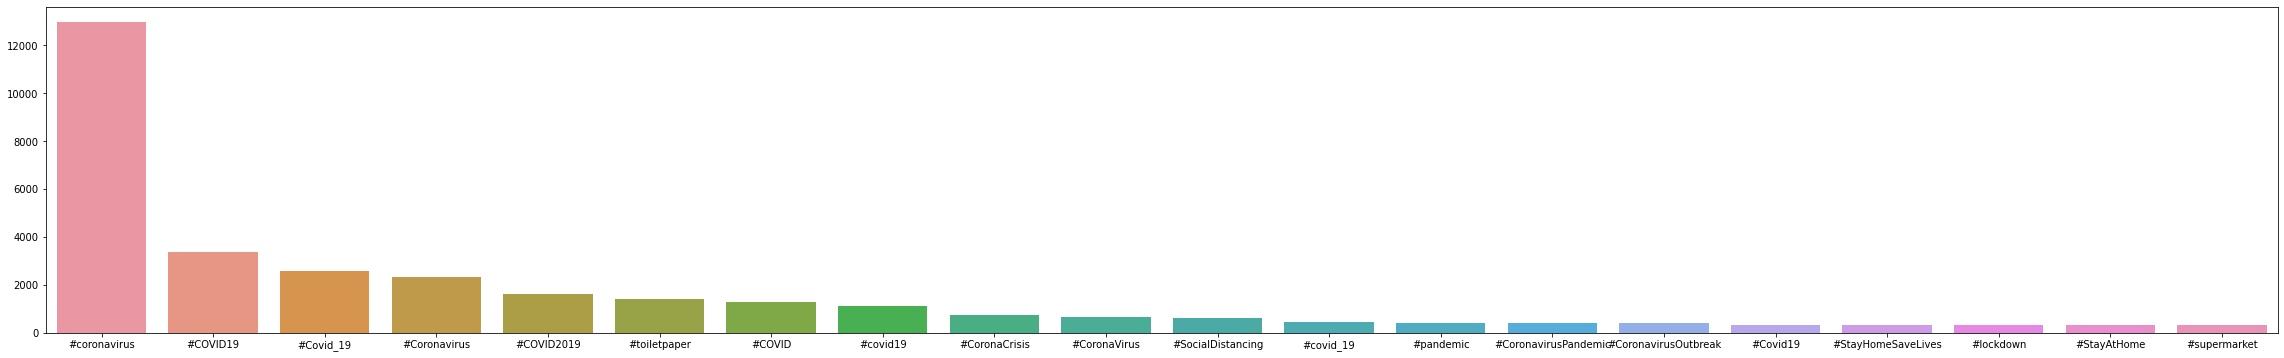

In [32]:
plt.figure(figsize=(40, 6))
sns.barplot(x=list(temp.keys()), y=list(temp.values()))
plt.show()

In [42]:
dict_ht = []
for ht in temp:
    for row in range(len(vid_train)):
        if ht in vid_train['OriginalTweet'].iloc[row]:
            senti = vid_train['Sentiment'].iloc[row]
            if senti == 'Extremely Negative':
                senti = 'Negative'
            elif senti == 'Extremely Positive':
                senti = 'Positive'
            dict_ht.append([ht, senti])

In [43]:
ht_temp_df = pd.DataFrame(dict_ht, columns=['Tag', 'Sentiment'])

Если посмотреть статистику появлений основных хэштегов, то везде прослеживается одна и та же тендеция: чаще представлены в позитивных текстах, реже - в негативных, что также связано с самим перевесом позитивного класса в выборке.

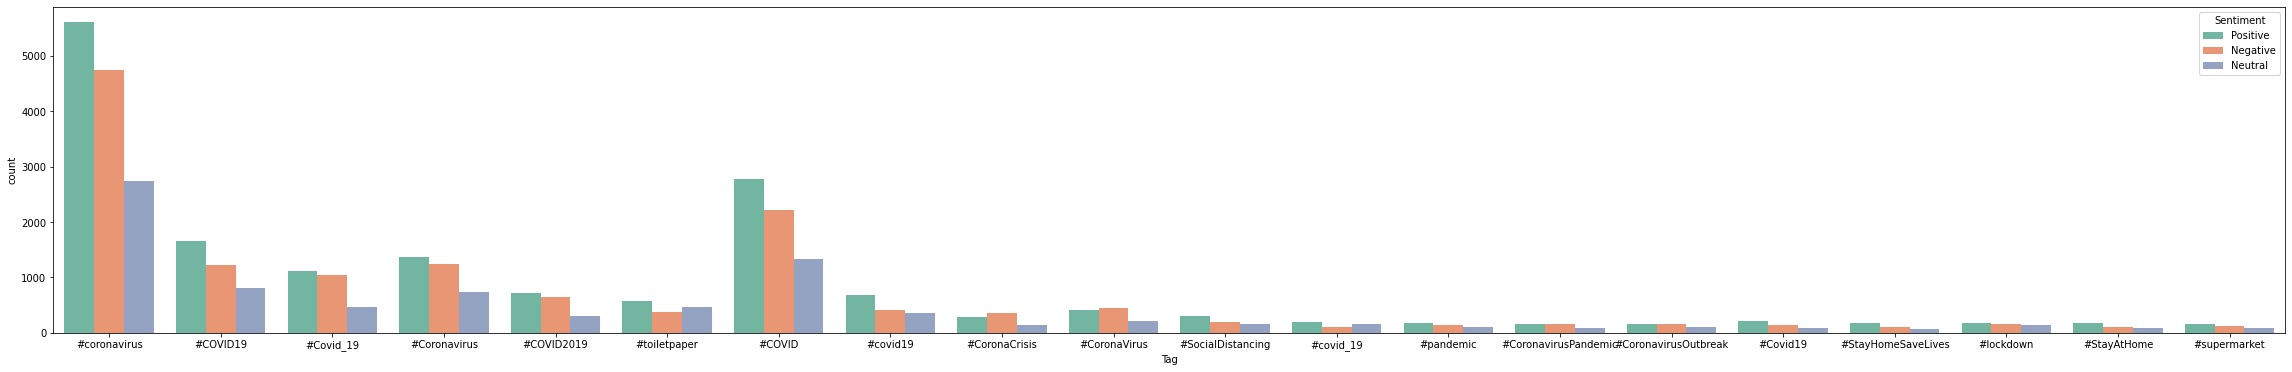

In [47]:
plt.figure(figsize=(40, 6))
sns.countplot(data=ht_temp_df, x="Tag", hue="Sentiment", palette='Set2')
plt.show()

примеры позитивного и негативного текстов для хэштега 'StayAtHome'

In [ ]:
plus = 0
minus = 0
for row in range(len(vid_train)-1,0,-1):
    if plus == 0:
        if '#StayAtHome' in vid_train['OriginalTweet'].iloc[row] and vid_train['Sentiment'].iloc[row] in ['Positive', 'Extremely Positive']:
            print('-'*100)
            print('Positive Tweet')
            print(vid_train['OriginalTweet'].iloc[row])
            plus = 1
    if minus == 0:
        if '#StayAtHome' in vid_train['OriginalTweet'].iloc[row] and vid_train['Sentiment'].iloc[row] in ['Negative', 'Extremely Negative']:
            print('-'*100)
            print('Negative Tweet')
            print(vid_train['OriginalTweet'].iloc[row])
            minus = 1

----------------------------------------------------------------------------------------------------
Positive Tweet
If you have rubbing alcohol you don't need mix it with aloe to make sanitizer. Just use the alcohol to directly clean your hands!  #Coronavirus #Covid19 #StayAtHome *If you are concerned about your skin moisturize!
----------------------------------------------------------------------------------------------------
Negative Tweet





#StayAtHome Day 16


То же касается упоминаний (@). Упоминаемые персоны (Трамп, Борис Джонсон), компании (Walmart, Amazon) и медиа (CNN) могут быть как в негативных, так и позитивных контекстах. Поэтому в сентимент-анализе таких твитов скорее следует анализировать непосредственно текст сообщения, чем хэштеги и упоминания.

In [48]:
def get_mentions(tweet):
    mention = re.findall(r'@\w+',tweet)
    return mention

In [49]:
found_ht = []
for row in range(len(vid_train)):
    found_ht += get_mentions(vid_train.OriginalTweet.iloc[row])

counter_ht = Counter(found_ht)
temp = OrderedDict(counter_ht.most_common(20))

In [50]:
print('Top-20 mentions:')
for i in temp:
    print(i, end=', ')

Top-20 mentions:
@realDonaldTrump, @Tesco, @sainsburys, @BorisJohnson, @narendramodi, @amazon, @asda, @PMOIndia, @Morrisons, @piersmorgan, @YouTube, @waitrose, @CNN, @AldiUK, @Walmart, @FTC, @CDCgov, @NYGovCuomo, @BBCNews, @SkyNews, 

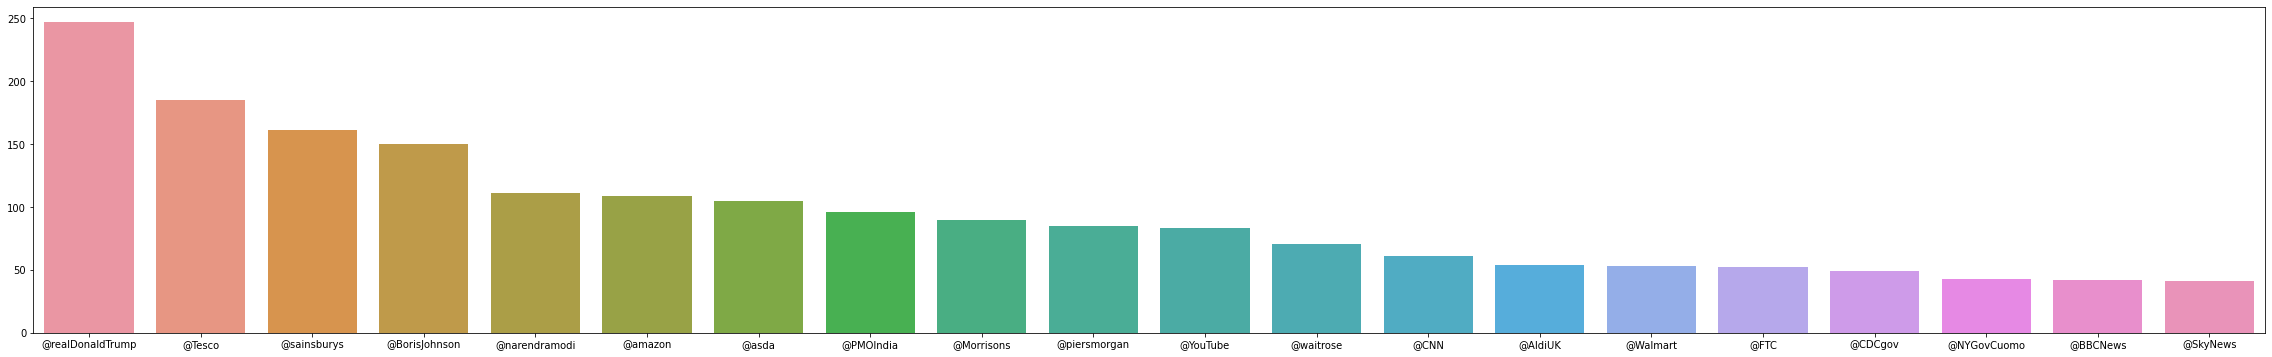

In [ ]:
plt.figure(figsize=(40, 6))
sns.barplot(x=list(temp.keys()), y=list(temp.values()))
plt.show()

In [51]:
dict_mt = []
for mt in temp:
    for row in range(len(vid_train)):
        if mt in vid_train['OriginalTweet'].iloc[row]:
            senti = vid_train['Sentiment'].iloc[row]
            if senti == 'Extremely Negative':
                senti = 'Negative'
            elif senti == 'Extremely Positive':
                senti = 'Positive'
            dict_mt.append([mt, senti])

In [52]:
mt_temp_df = pd.DataFrame(dict_mt, columns=['Mention', 'Sentiment'])

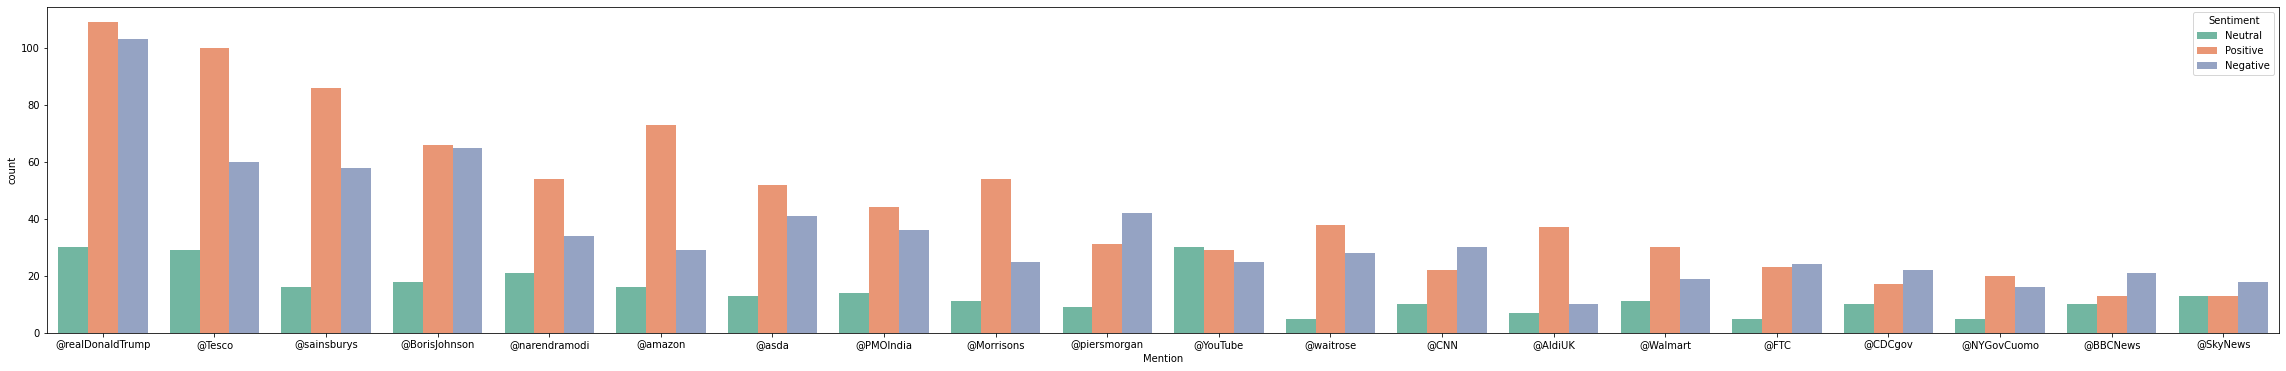

In [53]:
plt.figure(figsize=(40, 6))
sns.countplot(data=mt_temp_df, x="Mention", hue="Sentiment", palette='Set2')
plt.show()

При детальном рассмотрении упоминаний, также оказывется, что большая часть - позитивная, отдельные аккаунты, однако, чаще появляются в негативных контекстах: СМИ - CNN, BBCNews, @piersmorgan, правительственные аккаунты (CDCgov)

In [ ]:
def get_tweet_len(tweet):
    tokens = word_tokenize(tweet)
    return len(tokens)

lens = []
for row in range(len(vid_train)):
    lens.append(get_tweet_len(vid_train['OriginalTweet'].iloc[row]))

print('Max:', max(lens))
print('Moda:', round(np.median(lens)))
print('Mean:', round(np.mean(lens)))
print('Min:', min(lens))

Max: 205
Moda: 39
Mean: 37
Min: 1


Как видно, в основном число слов в твите <40, исключение составляют твиты-выбросы, состоящие из пунктуации, ссылок и числовых значений. Все они будут удалены на этапе предобработки.

## Basic Preprocessing

Проведем базовую предобработку твитов, пока без удаления #хэштегов и @упоминаний, так как они гипотетически могут являться определяющими для сентимент-анализа. Поэтому очистим датасет только от ссылок и несчитываемых символов.

In [54]:
def clean_tweet(tweet):
    clean = re.sub(r'https://t.co/\w*\s?', '', tweet)
    clean = re.sub(r'[^\x00-\x7f]','', clean) 
    
    return clean.strip()

In [55]:
vid_train['CleanTweet']= vid_train['OriginalTweet'].apply(lambda x: clean_tweet(x))

Пример очищенного предложения:

In [56]:
print('Было:\n', vid_train.OriginalTweet.iloc[5])
print('_'*50)
print('Стало:\n', vid_train.CleanTweet.iloc[5])

Было:
 As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU
__________________________________________________
Стало:
 As news of the regions first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports


In [57]:
vid_test['CleanTweet']= vid_test['OriginalTweet'].apply(lambda x: clean_tweet(x))

Лемматизируем твиты и удалим стоп-слова с помощью библиотеки nltk

In [58]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [59]:
def basic_preprocess(tweet):
    tokens = word_tokenize(tweet)
    
    preprocessed = []
    for tok in tokens:
        lemma = lemmatizer.lemmatize(tok).lower()
        if lemma not in stop_words and not bool(re.match(f'^[\d{string.punctuation}]+$', lemma)):
            preprocessed.append(lemma)
    return ' '.join(preprocessed)

vid_train['LemTweet']= vid_train['CleanTweet'].apply(lambda x: basic_preprocess(x))    
vid_test['LemTweet']= vid_test['CleanTweet'].apply(lambda x: basic_preprocess(x))

Пример очищенного предложения

In [60]:
vid_train.LemTweet.iloc[5]

'news region first confirmed covid-19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good tim_dodson report'

In [61]:
print(vid_train.shape, vid_test.shape)

(41157, 8) (3798, 8)


Перед обучением удалим дубли твитов и образовавшиеся пустые строки.

In [62]:
vid_train = vid_train.drop_duplicates(subset=['LemTweet'])
vid_train = vid_train[vid_train.LemTweet != '']
vid_test = vid_test.drop_duplicates(subset=['LemTweet'])
vid_test = vid_test[vid_test.LemTweet != '']

In [63]:
print(vid_train.shape, vid_test.shape)

(40983, 8) (3789, 8)


### Basic ML

Для базовых ML алгоритмов используем TF*IDF с ограничением словаря до 5к токенов.

In [64]:
label_enc = LabelEncoder()

y_train = label_enc.fit_transform(vid_train["Sentiment"])
y_test  = label_enc.transform(vid_test["Sentiment"])

In [65]:
for i in label_enc.classes_:
    print(i, ':', label_enc.transform([i]))

Extremely Negative : [0]
Extremely Positive : [1]
Negative : [2]
Neutral : [3]
Positive : [4]


In [66]:
tfidf_enc = TfidfVectorizer(max_features=5000)
X_train = tfidf_enc.fit_transform(vid_train['LemTweet'])
X_test = tfidf_enc.transform(vid_test['LemTweet'])

#### Logistic Regression

В качестве бейзлайна посмотрим качество при применении логистической регрессии.

In [ ]:
def print_results(preds):
    y_train, y_pred_train, y_test, y_pred_test = preds

    val_f1 = f1_score(y_test, y_pred_test, average='weighted')
    val_precision = precision_score(y_test, y_pred_test, average='weighted')
    val_recall = recall_score(y_test, y_pred_test, average='weighted')
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')

    print("TRAIN F1: {0:.3f}".format(train_f1))
    print('_____________________________________________________')

    print("Validation F1: {0:.3f}".format(val_f1))
    print("Validation Precision: {0:.3f}".format(val_precision))
    print("Validation Recall: {0:.3f}".format(val_recall))
    print('_____________________________________________________')

    print(classification_report(y_test, y_pred_test))

In [ ]:
classifier = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=1.0, max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

train_predict = classifier.predict(X_train)
test_predict = classifier.predict(X_test)

print_results([y_train, train_predict, y_test, test_predict])

TRAIN F1: 0.726
_____________________________________________________
Validation F1: 0.622
Validation Precision: 0.630
Validation Recall: 0.623
_____________________________________________________
              precision    recall  f1-score   support

           0       0.68      0.52      0.59       591
           1       0.76      0.62      0.68       599
           2       0.56      0.55      0.56      1038
           3       0.65      0.77      0.71       615
           4       0.57      0.67      0.62       946

    accuracy                           0.62      3789
   macro avg       0.65      0.63      0.63      3789
weighted avg       0.63      0.62      0.62      3789



[0] Extremely Negative

[1] Extremely Positive

[2] Negative

[3] Neutral

[4] Positive
_______________________
Логистическая регрессия с подобранными параметрами показывает низкие результаты для негативного (2) и сильно негативного (0) классов.

Для оценки качества здесь и далее рассматривается взвешенный F1-score из-за несбалансированности датасета

#### SVM

In [ ]:
def GridKFold(model, parameters):
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    gridSearch = GridSearchCV(model, parameters, scoring='f1_weighted', cv=kfold, verbose=3)
    gridSearch.fit(X_train, y_train)
    print("Best parameters set:")
    best_parameters = gridSearch.best_estimator_.get_params()
    for parameterName in sorted(parameters.keys()):
        print("\t%s: %r" % (parameterName, best_parameters[parameterName]))
    
    y_pred = gridSearch.predict(X_test)
    y_train_pred = gridSearch.predict(X_train)

    val_f1 = f1_score(y_test, y_pred, average='weighted')
    val_precision = precision_score(y_test, y_pred, average='weighted')
    val_recall = recall_score(y_test, y_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')


    print("TRAIN F1: {0:.3f}".format(train_f1))
    print('_____________________________________________________')

    print("Validation F1: {0:.3f}".format(val_f1))
    print("Validation Precision: {0:.3f}".format(val_precision))
    print("Validation Recall: {0:.3f}".format(val_recall))
    print('_____________________________________________________')

    print(classification_report(y_test, y_pred))

In [ ]:
svc_clf = SVC()
svc_params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 0.5, 1.0, 1.5, 2.0]}
GridKFold(svc_clf, svc_params)

Best parameters set:
	SVC__C: 2.0
	SVC__kernel: 'linear'
TRAIN F1: 0.802
_____________________________________________________
Validation F1: 0.623
Validation Precision: 0.628
Validation Recall: 0.623
_____________________________________________________
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       591
           1       0.72      0.61      0.66       599
           2       0.56      0.57      0.57      1038
           3       0.71      0.72      0.71       615
           4       0.57      0.67      0.62       946

    accuracy                           0.62      3789
   macro avg       0.64      0.62      0.63      3789
weighted avg       0.63      0.62      0.62      3789



[0] Extremely Negative

[1] Extremely Positive

[2] Negative

[3] Neutral

[4] Positive
___________________________________
Качество SVC приблизительно такое же, как и для лог регрессии - также результаты для негативных классов ниже. Вопреки предположению, что крайние (сильный негатив или позитив) классы будут хуже предсказываться из-за их доли в выборке
, оценка и для позитивного, и для негативного классов ниже, чем у классов с более сильной семантикой, что как раз может быть связано с выбранным способом векторизации с помощью TF*IDF - при расчете выявляются тематические слова, которые и могут быть более широко представлены в extreme классах.

 Можно, однако, отметить чуть большее переобучение (0.726 на трейне в лог.рег и 0.802 для линейного svm)

### Basic NN

В качестве нейронных сетей рассмотрим сетки с двунаправленным lstm и со сверточным слоем. Кодироваться последовательности будут с помощью слоя Embedding с рандомной инициализацией.

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(vid_train['LemTweet'].values)
wordIndex = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % (wordIndex))

Found 53102 unique tokens.


Преобразуем данные для сеток, максимальная длина последовательности - 40, как определили по среднему всех длин твитов.

In [ ]:
X_train = tokenizer.texts_to_sequences(vid_train['LemTweet'].values)
X_train = pad_sequences(X_train, maxlen=40)

X_test = tokenizer.texts_to_sequences(vid_test['LemTweet'].values)
X_test = pad_sequences(X_test, maxlen=40)

In [ ]:
X_train.shape, X_test.shape

((40983, 40), (3789, 40))

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Random init weights BiLSTM

Используем двунаправленный рекуррентный слой. Рекуррентность - для лучшего запоминания контекста. Был выбран LSTM вариант из-за механизма гейтов для фильтрации информации. Также будем использовать двунаправленный LSTM - таким образом будем лучше захватывать контекст и слева, и справа.

In [ ]:
model= models.Sequential()
model.add(layers.Embedding(wordIndex, 128, input_length=40))
model.add(layers.Bidirectional((layers.LSTM(512))))
model.add(Dropout(0.1))
model.add(layers.Dense(5, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 40, 128)           6797056   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1024)             2625536   
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 9,427,717
Trainable params: 9,427,717
Non-trainable params: 0
_________________________________________________________________


In [ ]:
metric = tfa.metrics.FBetaScore(num_classes=5, beta=2.0, threshold=0.5)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-05),
              metrics=[metric])

In [ ]:
history = model.fit(X_train ,y_train, batch_size=250, epochs=100, validation_split=0.2,)

Epoch 1/100
132/132 [==============================] - 15s 83ms/step - loss: 1.5907 - fbeta_score: 0.3624 - val_loss: 1.5642 - val_fbeta_score: 0.3632
Epoch 2/100
132/132 [==============================] - 10s 73ms/step - loss: 1.5547 - fbeta_score: 0.3647 - val_loss: 1.5303 - val_fbeta_score: 0.3729
Epoch 3/100
132/132 [==============================] - 10s 73ms/step - loss: 1.5205 - fbeta_score: 0.4774 - val_loss: 1.5091 - val_fbeta_score: 0.5035
Epoch 4/100
132/132 [==============================] - 9s 68ms/step - loss: 1.5140 - fbeta_score: 0.5077 - val_loss: 1.5088 - val_fbeta_score: 0.4885
Epoch 5/100
132/132 [==============================] - 9s 66ms/step - loss: 1.5111 - fbeta_score: 0.5067 - val_loss: 1.5054 - val_fbeta_score: 0.5083
Epoch 6/100
132/132 [==============================] - 9s 66ms/step - loss: 1.5091 - fbeta_score: 0.5079 - val_loss: 1.5027 - val_fbeta_score: 0.5076
Epoch 7/100
132/132 [==============================] - 9s 66ms/step - loss: 1.5071 - fbeta_score:

In [ ]:
y_pred = model.predict(X_test)

119/119 [==============================] - 2s 5ms/step


In [ ]:
print(classification_report(np.argmax(y_test, 1), np.argmax(y_pred, 1), digits=5))

              precision    recall  f1-score   support

           0    0.75468   0.61421   0.67724       591
           1    0.75862   0.73456   0.74640       599
           2    0.62279   0.61079   0.61673      1038
           3    0.67770   0.63252   0.65433       615
           4    0.58803   0.70613   0.64169       946

    accuracy                        0.65822      3789
   macro avg    0.68036   0.65964   0.66728      3789
weighted avg    0.66507   0.65822   0.65900      3789



[0] Extremely Negative

[1] Extremely Positive

[2] Negative

[3] Neutral

[4] Positive
___________________________________
Обучив сетку на 100 эпохах получаем взвешенную оценку 0.66, что выше, чем у базовых ML алгоритмов. Однако понижается качество для нейтрального класса (3). Для ML ~0.71, здесь же - 0.65. Лучшее качество получают классы с экстремальным выражением тональности (0, 1). То есть опять же лучше предсказываются предложения со специфической лексикой.

#### Random init weights CNN

Также рассмотрим качество при применении сверточной сети. Будем использовать свертку с размерностью 1 и окном=3. При следующем наборе слоев получено лучшее качество. Эксперименты также проводились с несколькими свертками с разным kernel_size, разным режимом пулинга - average и max. Предполагаем, что при свертке с окном=3 как раз будут выделяться словесные 3-граммы (обычно специфические словосочетания как раз представлены двумя или тремя словами), более всего влияющие на конечное предсказание.

In [ ]:
model= models.Sequential()
model.add(layers.Embedding(wordIndex, 128, input_length=40))

model.add(layers.Conv1D(filters=512, kernel_size=3, activation='tanh'))
model.add(layers.AveragePooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(Dropout(0.1))
model.add(layers.Dense(64, activation='tanh'))

model.add(layers.Dense(5, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 128)           6797056   
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 512)           197120    
                                                                 
 average_pooling1d_2 (Averag  (None, 19, 512)          0         
 ePooling1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 9728)              0         
                                                                 
 dropout_2 (Dropout)         (None, 9728)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                622656    
                                                      

In [ ]:
metric = tfa.metrics.FBetaScore(num_classes=5, beta=2.0, threshold=0.5)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-05),
              metrics=[metric])

In [ ]:
history = model.fit(X_train ,y_train, batch_size=250, epochs=100, validation_split=0.2,)

Epoch 1/100
132/132 [==============================] - 3s 16ms/step - loss: 1.5668 - fbeta_score: 0.3975 - val_loss: 1.5429 - val_fbeta_score: 0.3767
Epoch 2/100
132/132 [==============================] - 2s 14ms/step - loss: 1.5369 - fbeta_score: 0.4235 - val_loss: 1.5221 - val_fbeta_score: 0.4500
Epoch 3/100
132/132 [==============================] - 2s 14ms/step - loss: 1.5198 - fbeta_score: 0.4704 - val_loss: 1.5091 - val_fbeta_score: 0.4887
Epoch 4/100
132/132 [==============================] - 2s 14ms/step - loss: 1.5114 - fbeta_score: 0.5038 - val_loss: 1.5049 - val_fbeta_score: 0.5020
Epoch 5/100
132/132 [==============================] - 2s 14ms/step - loss: 1.5061 - fbeta_score: 0.5184 - val_loss: 1.5004 - val_fbeta_score: 0.5148
Epoch 6/100
132/132 [==============================] - 2s 14ms/step - loss: 1.5007 - fbeta_score: 0.5261 - val_loss: 1.4955 - val_fbeta_score: 0.5196
Epoch 7/100
132/132 [==============================] - 2s 14ms/step - loss: 1.4939 - fbeta_score: 0.

На валидации Свертка показывает себя несколько хуже, чем BiLSTM. На последней эпохе у LSTM оценка 0.7167, здесь - 0.7018.

In [ ]:
y_pred = model.predict(X_test)

119/119 [==============================] - 0s 2ms/step


In [ ]:
print(classification_report(np.argmax(y_test, 1), np.argmax(y_pred, 1), digits=5))

              precision    recall  f1-score   support

           0    0.73735   0.64129   0.68597       591
           1    0.78938   0.71953   0.75284       599
           2    0.60933   0.60405   0.60668      1038
           3    0.68595   0.67480   0.68033       615
           4    0.60274   0.69767   0.64674       946

    accuracy                        0.66297      3789
   macro avg    0.68495   0.66747   0.67451      3789
weighted avg    0.66855   0.66297   0.66411      3789



[0] Extremely Negative

[1] Extremely Positive

[2] Negative

[3] Neutral

[4] Positive
___________________________________
В целом, результат на тестовой выборке сравним с LSTM, наблюдается также улучшение по нейтральном классу и обоим экстремальным.

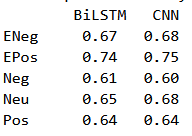

## Different Preprocessing

Добавим теперь полную очистку от хэштегов и упоминаний

In [ ]:
def clean_tweet(tweet):
    clean_tweet = re.sub(r'[@#]\w+\s?', '', tweet)
    clean_tweet = re.sub(r'https://t.co/\w*\s?', '', clean_tweet)
    clean_tweet = re.sub(r'[^\x00-\x7f]','', clean_tweet) 
    
    return clean_tweet.strip()

In [ ]:
vid_train['CleanerTweet']= vid_train['OriginalTweet'].apply(lambda x: clean_tweet(x))
vid_test['CleanerTweet']= vid_test['OriginalTweet'].apply(lambda x: clean_tweet(x))

In [ ]:
print('Было:\n', vid_train.OriginalTweet.iloc[5])
print('_'*50)
print('Стало:\n', vid_train.CleanerTweet.iloc[5])

Было:
 As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU
__________________________________________________
Стало:
 As news of the regions first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, reports


In [ ]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [ ]:
def basic_preprocess(tweet):
    tokens = word_tokenize(tweet)
    
    preprocessed = []
    for tok in tokens:
        lemma = lemmatizer.lemmatize(tok).lower()
        if lemma not in stop_words and not bool(re.match(f'^[\d{string.punctuation}]+$', lemma)):
            preprocessed.append(lemma)
    return ' '.join(preprocessed)

vid_train['LemTweet']= vid_train['CleanerTweet'].apply(lambda x: basic_preprocess(x))    
vid_test['LemTweet']= vid_test['CleanerTweet'].apply(lambda x: basic_preprocess(x))

In [ ]:
vid_train['LemTweet']= vid_train['CleanerTweet'].apply(lambda x: basic_preprocess(x))    
vid_test['LemTweet']= vid_test['CleanerTweet'].apply(lambda x: basic_preprocess(x))

In [ ]:
print(vid_train.shape, vid_test.shape)

(41157, 8) (3798, 8)


In [ ]:
vid_train = vid_train.drop_duplicates(subset=['LemTweet'])
vid_train = vid_train[vid_train['LemTweet'] != '']
vid_test = vid_test.drop_duplicates(subset=['LemTweet'])
vid_test = vid_test[vid_test['LemTweet'] != '']

In [ ]:
print(vid_train.shape, vid_test.shape)

(40823, 8) (3784, 8)


In [ ]:
label_enc = LabelEncoder()

y_train = label_enc.fit_transform(vid_train["Sentiment"])
y_test  = label_enc.transform(vid_test["Sentiment"])

### ML

Используем теперь для векторного представления предобученные эмбеддинги Fasttext. Фактически будем представлять текст как вектор, полученный усреднением векторов слов, которые есть в этом тексте, а также и в словаре от Fasttext. Так как Fasttext не включает цифровые символы, будем терять некоторые ключевые слова, содержащие в том числе цифры. Также будут потеряны вектора для слов, не входящих в словарь (например, covid).

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Магистериум/NLP/crawl-300d-2M-subword.vec')

In [ ]:
X_train = []
y_train = []
for row in range(len(vid_train)):
    temp_repr = []

    unprocessed = vid_train['LemTweet_'].iloc[row].split()
    for tok in unprocessed:
        try:
            if temp_repr == []:
                temp_repr = [word_vectors.word_vec(tok)]
                continue
            else:
                temp_repr = np.concatenate((temp_repr, [word_vectors.word_vec(tok)]), axis=0)
        except KeyError:
            pass
    if temp_repr != []:
        # вектор твита - усреднением
        X_train.append(np.mean(temp_repr, axis=0))
        y_train.append(vid_train['Sentiment'].iloc[row])
X_train = np.array(X_train)

In [ ]:
X_test = []
y_test = []
for row in range(len(vid_test)):
    temp_repr = []

    unprocessed = vid_test['LemTweet_'].iloc[row].split()
    for tok in unprocessed:
        try:
            if temp_repr == []:
                temp_repr = [word_vectors.word_vec(tok)]
                continue
            else:
                temp_repr = np.concatenate((temp_repr, [word_vectors.word_vec(tok)]), axis=0)
        except KeyError:
            pass
    if temp_repr != []:
        X_test.append(np.mean(temp_repr, axis=0))
        y_test.append(vid_test['Sentiment'].iloc[row])
X_test = np.array(X_test)

Будем также использовать Логическую регрессию и SVM, но с донастройкой параметров.

Для начала также будем использовать TF*IDF, чтобы посмотреть, изменяется ли качество при уделнии хэштегов и упоминаний. 

In [ ]:
tfidf_enc = TfidfVectorizer(max_features=5000)
X_train_tf = tfidf_enc.fit_transform(vid_train['LemTweet'])
X_test_tf = tfidf_enc.transform(vid_test['LemTweet'])

#### Logistic Regression

In [ ]:
classifier = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=1.0, max_iter=1000, random_state=42)
classifier.fit(X_train_tf, y_train)

train_predict = classifier.predict(X_train_tf)

test_predict = classifier.predict(X_test_tf)

print_results([y_train, train_predict, y_test, test_predict])

TRAIN F1: 0.734
_____________________________________________________
Validation F1: 0.637
Validation Precision: 0.646
Validation Recall: 0.639
_____________________________________________________
              precision    recall  f1-score   support

           0       0.71      0.53      0.61       590
           1       0.77      0.62      0.68       597
           2       0.59      0.56      0.57      1040
           3       0.66      0.80      0.72       611
           4       0.59      0.70      0.64       946

    accuracy                           0.64      3784
   macro avg       0.66      0.64      0.65      3784
weighted avg       0.65      0.64      0.64      3784



[0] Extremely Negative

[1] Extremely Positive

[2] Negative

[3] Neutral

[4] Positive
_______________________
При сравнении видим, что есть улучшение качества по всем классам при удалении хэштегов и упоминаний и сохранении прежних гиперпараметров.

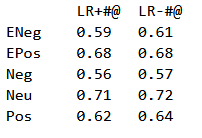


Теперь обучим логистическую регрессию (с донастроенными уже параметрами) на векторных представлениях, полученных с помощью Fasttext. Видим, что при таком способе кодировки, качество существенно снижается.

In [ ]:
classifier = LogisticRegression(penalty='l1', solver='', max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

train_predict = classifier.predict(X_train)
test_predict = classifier.predict(X_test)

print_results([y_train, train_predict, y_test, test_predict])

TRAIN F1: 0.499
_____________________________________________________
Validation F1: 0.467
Validation Precision: 0.498
Validation Recall: 0.469
_____________________________________________________
              precision    recall  f1-score   support

           0       0.62      0.34      0.44       589
           1       0.64      0.34      0.45       597
           2       0.45      0.50      0.47      1040
           3       0.50      0.58      0.53       611
           4       0.39      0.53      0.45       946

    accuracy                           0.47      3783
   macro avg       0.52      0.46      0.47      3783
weighted avg       0.50      0.47      0.47      3783



#### SVM

Также рассмотрим изменение оценки на SVM при удалении хэштегов и упоминаний.

In [ ]:
classifier = SVC(kernel='linear', C=2.0, random_state=42)
classifier.fit(X_train_tf, y_train)

train_predict = classifier.predict(X_train_tf)

test_predict = classifier.predict(X_test_tf)

print_results([y_train, train_predict, y_test, test_predict])

TRAIN F1: 0.815
_____________________________________________________
Validation F1: 0.652
Validation Precision: 0.656
Validation Recall: 0.651
_____________________________________________________
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       590
           1       0.75      0.65      0.69       597
           2       0.59      0.61      0.60      1040
           3       0.75      0.75      0.75       611
           4       0.60      0.69      0.64       946

    accuracy                           0.65      3784
   macro avg       0.67      0.65      0.66      3784
weighted avg       0.66      0.65      0.65      3784



Для SVM также результат улучшается при очистки твитов от упоминаний и хэштегов. Также качество получается лучше, чем для логистической регрессии.

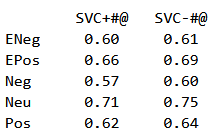

При этом при использовании Fasttext также качество предсказания плохое, однако все же при донастройке несколько лучше, чем у логистической регрессии.

In [ ]:
classifier = SVC(kernel='rbf', C=2.0)

classifier.fit(X_train, y_train)

train_predict = classifier.predict(X_train)
test_predict = classifier.predict(X_test)

print_results([y_train, train_predict, y_test, test_predict])

TRAIN F1: 0.631
_____________________________________________________
Validation F1: 0.535
Validation Precision: 0.553
Validation Recall: 0.531
_____________________________________________________
              precision    recall  f1-score   support

           0       0.61      0.48      0.54       589
           1       0.69      0.49      0.57       597
           2       0.47      0.52      0.50      1040
           3       0.68      0.58      0.63       611
           4       0.44      0.57      0.49       946

    accuracy                           0.53      3783
   macro avg       0.58      0.53      0.55      3783
weighted avg       0.55      0.53      0.54      3783



### NN

Для тестирования возьмем прежние нейронные сети, однико будем использовать также представления от Fasttext.

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(vid_train['LemTweet'].values)
wordIndex = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % (wordIndex))

Found 32591 unique tokens.


In [ ]:
# Turns the lists of integers into a 2D integer tensor of shape (numWords, maxlen)
X_train = tokenizer.texts_to_sequences(vid_train['LemTweet'].values)
X_train = pad_sequences(X_train, maxlen=40)

X_test = tokenizer.texts_to_sequences(vid_test['LemTweet'].values)
X_test = pad_sequences(X_test, maxlen=40)

In [ ]:
label_enc = LabelEncoder()

y_train = label_enc.fit_transform(vid_train["Sentiment"])
y_test  = label_enc.transform(vid_test["Sentiment"])

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
word_vectors = {}
f = io.open("/content/gdrive/My Drive/Магистериум/NLP/crawl-300d-2M-subword.vec", encoding='utf-8')
n, d = map(int, f.readline().split())
for line in tqdm(f):
    values = line.rstrip().split(' ')
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    word_vectors[word] = vector
f.close()
print(f'found {len(word_vectors)} word vectors')

2000000it [01:54, 17396.07it/s]

found 2000000 word vectors


Будем передавать в качестве предобученных весов слою Embedding матрицу представлений для слов, встречающихся в данных, вектора для них все так же будем брать из Fasttext. В случае отсутствия вектора для слова в Fasttext, в процессе обучения модели будет получен вектор для out-of-vocab слова.

In [ ]:
word_index = tokenizer.word_index
nb_words = min(1e5, len(word_index))

embedding_matrix = np.zeros((nb_words+1, 300))

for word, i in word_index.items():
    if i > nb_words:
        break
    vector = word_vectors.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

#### Fasttext Emb + BiLSTM

In [ ]:
model= models.Sequential()
model.add(layers.Embedding(wordIndex, 300, weights=[embedding_matrix], input_length=40))
model.add(layers.Bidirectional((layers.LSTM(512))))
model.add(Dropout(0.1))
model.add(layers.Dense(5, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           9777300   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 13,112,473
Trainable params: 13,112,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
metric = tfa.metrics.FBetaScore(num_classes=5, beta=2.0, threshold=0.5)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-05),
              metrics=[metric])


In [ ]:
history = model.fit(X_train ,y_train, batch_size=250, epochs=100, validation_split=0.2,)

Epoch 1/100
131/131 [==============================] - 19s 85ms/step - loss: 1.5909 - fbeta_score: 0.2938 - val_loss: 1.5714 - val_fbeta_score: 0.2515
Epoch 2/100
131/131 [==============================] - 10s 79ms/step - loss: 1.5562 - fbeta_score: 0.3364 - val_loss: 1.5374 - val_fbeta_score: 0.4461
Epoch 3/100
131/131 [==============================] - 10s 80ms/step - loss: 1.4985 - fbeta_score: 0.5110 - val_loss: 1.4489 - val_fbeta_score: 0.5355
Epoch 4/100
131/131 [==============================] - 11s 81ms/step - loss: 1.4030 - fbeta_score: 0.5709 - val_loss: 1.3483 - val_fbeta_score: 0.5886
Epoch 5/100
131/131 [==============================] - 11s 83ms/step - loss: 1.3112 - fbeta_score: 0.6173 - val_loss: 1.2908 - val_fbeta_score: 0.6203
Epoch 6/100
131/131 [==============================] - 11s 86ms/step - loss: 1.2571 - fbeta_score: 0.6393 - val_loss: 1.2586 - val_fbeta_score: 0.6278
Epoch 7/100
131/131 [==============================] - 11s 83ms/step - loss: 1.2178 - fbeta_sc

In [ ]:
y_pred = model.predict(X_test)

119/119 [==============================] - 1s 6ms/step


In [ ]:
print(classification_report(np.argmax(y_test, 1), np.argmax(y_pred, 1), digits=5))

              precision    recall  f1-score   support

           0    0.68498   0.63390   0.65845       590
           1    0.75593   0.74707   0.75147       597
           2    0.55589   0.53558   0.54554      1040
           3    0.68385   0.65139   0.66723       611
           4    0.60432   0.67970   0.63980       946

    accuracy                        0.63901      3784
   macro avg    0.65699   0.64953   0.65250      3784
weighted avg    0.64035   0.63901   0.63885      3784



При использовании предобученных эмбеддингов получаем снижение качества (0.659 -> 0.638)

#### Fasttext Emb+Conv

In [ ]:
model= models.Sequential()
model.add(layers.Embedding(wordIndex, 300, weights=[embedding_matrix], input_length=40))

model.add(layers.Conv1D(filters=512, kernel_size=3, activation='tanh'))
model.add(layers.AveragePooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(Dropout(0.1))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(5, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           9777300   
                                                                 
 conv1d (Conv1D)             (None, 38, 512)           461312    
                                                                 
 average_pooling1d (AverageP  (None, 19, 512)          0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 9728)              0         
                                                                 
 dropout (Dropout)           (None, 9728)              0         
                                                                 
 dense (Dense)               (None, 64)                622656    
                                                        

In [ ]:
metric = tfa.metrics.FBetaScore(num_classes=5, beta=2.0, threshold=0.5)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-05),
              metrics=[metric])


In [ ]:
history = model.fit(X_train ,y_train, batch_size=250, epochs=100, validation_split=0.2,)

Epoch 1/100
131/131 [==============================] - 9s 22ms/step - loss: 1.5741 - fbeta_score: 0.3464 - val_loss: 1.5516 - val_fbeta_score: 0.3513
Epoch 2/100
131/131 [==============================] - 3s 19ms/step - loss: 1.5353 - fbeta_score: 0.3967 - val_loss: 1.5213 - val_fbeta_score: 0.4274
Epoch 3/100
131/131 [==============================] - 3s 19ms/step - loss: 1.5044 - fbeta_score: 0.4668 - val_loss: 1.4921 - val_fbeta_score: 0.4868
Epoch 4/100
131/131 [==============================] - 3s 19ms/step - loss: 1.4752 - fbeta_score: 0.5160 - val_loss: 1.4642 - val_fbeta_score: 0.5216
Epoch 5/100
131/131 [==============================] - 3s 19ms/step - loss: 1.4452 - fbeta_score: 0.5478 - val_loss: 1.4328 - val_fbeta_score: 0.5531
Epoch 6/100
131/131 [==============================] - 3s 20ms/step - loss: 1.4107 - fbeta_score: 0.5755 - val_loss: 1.3991 - val_fbeta_score: 0.5783
Epoch 7/100
131/131 [==============================] - 3s 19ms/step - loss: 1.3715 - fbeta_score: 0.

In [ ]:
y_pred = model.predict(X_test)

119/119 [==============================] - 0s 2ms/step


In [ ]:
print(classification_report(np.argmax(y_test, 1), np.argmax(y_pred, 1), digits=5))

              precision    recall  f1-score   support

           0    0.74803   0.64407   0.69217       590
           1    0.80830   0.68509   0.74161       597
           2    0.63060   0.65000   0.64015      1040
           3    0.70915   0.71031   0.70973       611
           4    0.61786   0.70930   0.66043       946

    accuracy                        0.67918      3784
   macro avg    0.70279   0.67975   0.68882      3784
weighted avg    0.68644   0.67918   0.68057      3784



Сверточная сеть с использованием Fasttext для инициализации Embedding слоя, однако, дает лучшие результаты среди всех ранее рассмотренных комбинаций алгоритмов, параметров и данных.


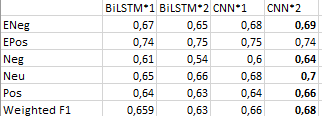

## BERT

В случае с анализом тональности больший эффект должны давать контекстуализированные эмбеддинги, которые и позовяют получить модели из семейства BERT. Используем для этого 2 варианта предобученных языковых моделей и дообучим для задачи сентимент-анализа на наших данных. 

1 вариант LM - стандартный предобученный берт bert-base-uncased. В английском регистр слов не играет большого значения, поэтому можно использовать версию uncased.

2 вариант LM - предобученный также на твитах про ковид digitalepidemiologylab/covid-twitter-bert (https://huggingface.co/digitalepidemiologylab/covid-twitter-bert-v2)

#### LM: bert-base-uncased

Подгрузим модель и используем генератор данных (DataCollatorWithPadding) с динамическим паддингом для батча (определяется наибольшая последовательность, остальные дополняются нулями до полученной длины).

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(vid_train.Sentiment.unique()))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
df_train = vid_train[['LemTweet_', 'Sentiment']].copy()
df_test = vid_test[['LemTweet_','Sentiment']].copy()

label_enc = LabelEncoder()
df_train['Sentiment'] = label_enc.fit_transform(vid_train["Sentiment"])
df_test['Sentiment'] = label_enc.transform(vid_test["Sentiment"])

df_train.columns = ['texts', 'labels']
df_test.columns = ['texts', 'labels']

In [ ]:
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

In [ ]:
def tokenize_function(item):
    tokenized_inputs = tokenizer(item['texts'])
    tokenized_inputs["labels"] = item['labels']
    return tokenized_inputs

In [ ]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_train = tokenized_train.remove_columns(['texts'])
tokenized_test = df_test.map(tokenize_function, batched=True)
tokenized_test = tokenized_test.remove_columns(['texts'])

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    print(classification_report(labels, predictions))

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        
    }

In [ ]:
import wandb
! wandb login

In [ ]:
wandb.init(project="nlp_lab_2")

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/gdrive/My Drive/Магистериум/NLP",
    report_to = 'wandb',
    do_train = True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=5,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    seed=42,
    )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  
)

In [ ]:
for i in label_enc.classes_:
    print(i, ':', label_enc.transform([i]))

Extremely Negative : [0]
Extremely Positive : [1]
Negative : [2]
Neutral : [3]
Positive : [4]


In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40823
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25515
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.597800,0.674178,0.767456,0.769865,0.766649
2,0.464200,0.735652,0.775026,0.776972,0.774049
3,0.393000,0.796826,0.772468,0.773561,0.772727
4,0.276100,1.009705,0.764068,0.765082,0.764535
5,0.252800,1.196835,0.769239,0.769249,0.769292


***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.82      0.74      0.78       590
           1       0.80      0.80      0.80       597
           2       0.70      0.77      0.73      1040
           3       0.87      0.82      0.84       611
           4       0.73      0.73      0.73       946

    accuracy                           0.77      3784
   macro avg       0.78      0.77      0.78      3784
weighted avg       0.77      0.77      0.77      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5103
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5103/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5103/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.79      0.76      0.78       590
           1       0.82      0.80      0.81       597
           2       0.72      0.74      0.73      1040
           3       0.89      0.82      0.85       611
           4       0.73      0.77      0.75       946

    accuracy                           0.77      3784
   macro avg       0.79      0.78      0.78      3784
weighted avg       0.78      0.77      0.78      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10206
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10206/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10206/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.74      0.82      0.78       590
           1       0.82      0.83      0.83       597
           2       0.74      0.69      0.71      1040
           3       0.86      0.81      0.83       611
           4       0.75      0.77      0.76       946

    accuracy                           0.77      3784
   macro avg       0.78      0.78      0.78      3784
weighted avg       0.77      0.77      0.77      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15309
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15309/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15309/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.77      0.80      0.78       590
           1       0.76      0.86      0.81       597
           2       0.74      0.70      0.72      1040
           3       0.85      0.79      0.82       611
           4       0.74      0.74      0.74       946

    accuracy                           0.76      3784
   macro avg       0.77      0.78      0.77      3784
weighted avg       0.77      0.76      0.76      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20412
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20412/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20412/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.78      0.79      0.79       590
           1       0.82      0.81      0.81       597
           2       0.73      0.72      0.73      1040
           3       0.80      0.81      0.81       611
           4       0.76      0.75      0.75       946

    accuracy                           0.77      3784
   macro avg       0.78      0.78      0.78      3784
weighted avg       0.77      0.77      0.77      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25515
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25515/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25515/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=25515, training_loss=0.41542872385536717, metrics={'train_runtime': 2656.6919, 'train_samples_per_second': 76.831, 'train_steps_per_second': 9.604, 'total_flos': 3607891900447650.0, 'train_loss': 0.41542872385536717, 'epoch': 5.0})

В результате обучения получаем лучшие значения на тесте на второй эпохе. При обучении используется предобработанный полностью текст - с удалением хэштегов и упоминаний, а также лемматизацией. Учитывая, что таким образом происходит потеря семантики твитов, а как следствие хуже проходит процесс файн-тьюнинга весов языковой модели для задачи, BERT дает результаты выше, чем были получены при экспериментах выше.


                       precision    recall  f1-score   support

                ENeg      0.79      0.76      0.78      590
                EPos      0.82      0.80      0.81      597
                Neg       0.72      0.74      0.73      1040
                Neu       0.89      0.82      0.85      611
                Pos       0.73      0.77      0.75      946
           
           accuracy                           0.77      3784
          macro avg       0.79      0.78      0.78      3784
       weighted avg       0.78      0.77      0.78      3784

#### LM: covid-twitter-bert
Теперь используем модель, предобученную на твитах той же тематики.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert")
model = AutoModelForSequenceClassification.from_pretrained("digitalepidemiologylab/covid-twitter-bert", num_labels=len(vid_train.Sentiment.unique()))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40823
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25515
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.648400,0.800210,0.722688,0.735350,0.722516
2,0.523900,0.663238,0.780187,0.782881,0.779070
3,0.437300,0.849716,0.776468,0.786766,0.774841
4,0.317200,1.111042,0.784333,0.786870,0.783562


***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.64      0.87      0.73       590
           1       0.90      0.65      0.75       597
           2       0.66      0.65      0.66      1040
           3       0.84      0.83      0.83       611
           4       0.70      0.69      0.70       946

    accuracy                           0.72      3784
   macro avg       0.75      0.74      0.74      3784
weighted avg       0.74      0.72      0.72      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5103
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5103/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5103/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.76      0.82      0.79       590
           1       0.84      0.81      0.82       597
           2       0.71      0.75      0.73      1040
           3       0.91      0.81      0.86       611
           4       0.76      0.75      0.76       946

    accuracy                           0.78      3784
   macro avg       0.80      0.79      0.79      3784
weighted avg       0.78      0.78      0.78      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10206
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10206/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10206/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.80      0.81      0.80       590
           1       0.92      0.69      0.79       597
           2       0.71      0.77      0.74      1040
           3       0.90      0.78      0.84       611
           4       0.71      0.81      0.76       946

    accuracy                           0.77      3784
   macro avg       0.81      0.77      0.78      3784
weighted avg       0.79      0.77      0.78      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15309
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15309/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15309/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3784
  Batch size = 8


              precision    recall  f1-score   support

           0       0.82      0.77      0.79       590
           1       0.85      0.76      0.81       597
           2       0.73      0.78      0.76      1040
           3       0.86      0.83      0.85       611
           4       0.74      0.77      0.76       946

    accuracy                           0.78      3784
   macro avg       0.80      0.78      0.79      3784
weighted avg       0.79      0.78      0.78      3784



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20412
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20412/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20412/pytorch_model.bin


С использованием предобученной на тематических твитах моделью получаем результаты чуть лучше (F1 = 0.775026 с простым бертом, F1 = 0.784333 со специальным).

Улучшается также качество для негативных классов (сильно негативный F1 0.78->0.79, негативный 0.73->0.76)


                    precision    recall  f1-score   support

               ENeg      0.82      0.77      0.79      590
               EPos      0.85      0.76      0.81      597
               Neg       0.73      0.78      0.76      1040
               Neu       0.86      0.83      0.85      611
               Pos       0.74      0.77      0.76      946

          accuracy                           0.78      3784
         macro avg       0.80      0.78      0.79      3784
      weighted avg       0.79      0.78      0.78      3784

### Тестирование BERT на нелемматизированных текстах

Как уже было предположено, лемматизация лишь ухудшает в случае с BERT итоговое качество. Для остальных моделей и алгоритмов она необходима для снижения размера словаря и, в случае с предобученными эмбеддингами типа w2v, получения векторов словарных слов, находящихся в начальной форме.

Для BERT же можно использовать тексты без лемматизации, относительно малый размер словаря достигается благодаря токенизации методом WordPiece (то есть слова разбиваются на подслова).

Проведем минимальную очистку датасета от ссылок и несчитываемых символов. То есть оставляем упоминания и хэштеги.

In [ ]:
def clean_tweet(tweet):
    clean = re.sub(r'https://t.co/\w*\s?', '', tweet)
    clean = re.sub(r'[^\x00-\x7f]','', clean) 
    
    return clean.lower().strip()

In [ ]:
vid_train['BertCleanTweet']= vid_train['OriginalTweet'].apply(lambda x: clean_tweet(x))
vid_test['BertCleanTweet']= vid_test['OriginalTweet'].apply(lambda x: clean_tweet(x))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert")
model = AutoModelForSequenceClassification.from_pretrained("digitalepidemiologylab/covid-twitter-bert", num_labels=len(vid_train.Sentiment.unique()))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
df_train = vid_train[['BertCleanTweet', 'Sentiment']].copy()
df_test = vid_test[['BertCleanTweet','Sentiment']].copy()

label_enc = LabelEncoder()
df_train['Sentiment'] = label_enc.fit_transform(vid_train["Sentiment"])
df_test['Sentiment'] = label_enc.transform(vid_test["Sentiment"])

df_train.columns = ['texts', 'labels']
df_test.columns = ['texts', 'labels']

In [ ]:
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 41157
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25725
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.532900,0.534679,0.820199,0.824972,0.819379
2,0.409100,0.518313,0.854714,0.855136,0.854660
3,0.253400,0.634673,0.866416,0.867276,0.866245
4,0.166100,0.647855,0.876920,0.878505,0.876514
5,0.083800,0.748469,0.876495,0.877442,0.876514


***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.82      0.89      0.85       592
           1       0.87      0.78      0.82       599
           2       0.81      0.80      0.80      1041
           3       0.94      0.81      0.87       619
           4       0.75      0.83      0.79       947

    accuracy                           0.82      3798
   macro avg       0.84      0.82      0.83      3798
weighted avg       0.82      0.82      0.82      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.89      0.85      0.87       592
           1       0.86      0.90      0.88       599
           2       0.84      0.83      0.84      1041
           3       0.90      0.87      0.88       619
           4       0.82      0.84      0.83       947

    accuracy                           0.85      3798
   macro avg       0.86      0.86      0.86      3798
weighted avg       0.86      0.85      0.85      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.90      0.88      0.89       592
           1       0.86      0.90      0.88       599
           2       0.87      0.85      0.86      1041
           3       0.90      0.86      0.88       619
           4       0.82      0.86      0.84       947

    accuracy                           0.87      3798
   macro avg       0.87      0.87      0.87      3798
weighted avg       0.87      0.87      0.87      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.89      0.88      0.89       592
           1       0.91      0.89      0.90       599
           2       0.87      0.86      0.86      1041
           3       0.94      0.86      0.90       619
           4       0.82      0.89      0.85       947

    accuracy                           0.88      3798
   macro avg       0.89      0.88      0.88      3798
weighted avg       0.88      0.88      0.88      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.89      0.90      0.89       592
           1       0.91      0.89      0.90       599
           2       0.88      0.85      0.87      1041
           3       0.83      0.92      0.87       619
           4       0.87      0.85      0.86       947

    accuracy                           0.88      3798
   macro avg       0.88      0.88      0.88      3798
weighted avg       0.88      0.88      0.88      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=25725, training_loss=0.3483551769052696, metrics={'train_runtime': 12307.3977, 'train_samples_per_second': 16.72, 'train_steps_per_second': 2.09, 'total_flos': 2.6330316638115944e+16, 'train_loss': 0.3483551769052696, 'epoch': 5.0})

Для языковой модели, предобученной на весах сразу получаем отличные результаты, на 0.1 выше: повышение значния взвешенной F-меры c 0.78  до 0.88


                   precision    recall  f1-score   support

            ENeg       0.89      0.88      0.89      592
            EPos       0.91      0.89      0.90      599
             Neg       0.87      0.86      0.86      1041
             Neu       0.94      0.86      0.90      619
             Pos       0.82      0.89      0.85      947

        accuracy                           0.88      3798
       macro avg       0.89      0.88      0.88      3798
    weighted avg       0.88      0.88      0.88      3798

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(vid_train.Sentiment.unique()))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 41157
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25725
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.514000,0.526440,0.811253,0.828060,0.809637
2,0.364300,0.529959,0.848280,0.851379,0.848078
3,0.272600,0.547013,0.868874,0.870475,0.868878
4,0.187200,0.658173,0.874574,0.875261,0.874408
5,0.120700,0.721563,0.869979,0.870374,0.870195


***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.91      0.71      0.80       592
           1       0.93      0.73      0.82       599
           2       0.74      0.86      0.80      1041
           3       0.96      0.80      0.87       619
           4       0.72      0.86      0.79       947

    accuracy                           0.81      3798
   macro avg       0.85      0.80      0.82      3798
weighted avg       0.83      0.81      0.81      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.83      0.92      0.87       592
           1       0.84      0.89      0.86       599
           2       0.81      0.84      0.82      1041
           3       0.96      0.84      0.90       619
           4       0.85      0.80      0.82       947

    accuracy                           0.85      3798
   macro avg       0.86      0.86      0.85      3798
weighted avg       0.85      0.85      0.85      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.86      0.92      0.89       592
           1       0.93      0.86      0.89       599
           2       0.86      0.83      0.84      1041
           3       0.90      0.86      0.88       619
           4       0.83      0.89      0.86       947

    accuracy                           0.87      3798
   macro avg       0.88      0.87      0.87      3798
weighted avg       0.87      0.87      0.87      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.90      0.88      0.89       592
           1       0.90      0.89      0.89       599
           2       0.86      0.85      0.86      1041
           3       0.91      0.88      0.89       619
           4       0.84      0.89      0.86       947

    accuracy                           0.87      3798
   macro avg       0.88      0.88      0.88      3798
weighted avg       0.88      0.87      0.87      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.87      0.92      0.89       592
           1       0.89      0.90      0.89       599
           2       0.88      0.84      0.86      1041
           3       0.85      0.88      0.87       619
           4       0.87      0.85      0.86       947

    accuracy                           0.87      3798
   macro avg       0.87      0.88      0.87      3798
weighted avg       0.87      0.87      0.87      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=25725, training_loss=0.3413659015503523, metrics={'train_runtime': 3789.5308, 'train_samples_per_second': 54.304, 'train_steps_per_second': 6.788, 'total_flos': 7433931352713324.0, 'train_loss': 0.3413659015503523, 'epoch': 5.0})

Для обычного BERT также качество повышается на 0.1 и сравнимо с языковой моделью, предобученной на твитах про ковид.

Теперь посмотрим, как будет показывать себя специальная модель при условии удаления упоминаний и хэштегов.

In [ ]:
def clean_tweet(tweet):
    clean = re.sub(r'[@#]\w+\s?', '', tweet)
    clean = re.sub(r'https://t.co/\w*\s?', '', clean)
    clean = re.sub(r'[^\x00-\x7f]', '', clean) 
    
    return clean.lower().strip()

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 41157
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25725
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.523100,0.501702,0.826039,0.830111,0.825961
2,0.385600,0.551708,0.839048,0.843692,0.839652
3,0.251400,0.557139,0.874811,0.876238,0.874671
4,0.160000,0.618701,0.884426,0.885074,0.884413
5,0.083500,0.709050,0.882304,0.882778,0.882306


***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.79      0.94      0.86       592
           1       0.85      0.79      0.82       599
           2       0.83      0.78      0.80      1041
           3       0.94      0.84      0.89       619
           4       0.77      0.82      0.79       947

    accuracy                           0.83      3798
   macro avg       0.84      0.83      0.83      3798
weighted avg       0.83      0.83      0.83      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-5145/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.76      0.93      0.84       592
           1       0.84      0.91      0.87       599
           2       0.86      0.76      0.80      1041
           3       0.92      0.86      0.89       619
           4       0.83      0.82      0.82       947

    accuracy                           0.84      3798
   macro avg       0.84      0.86      0.85      3798
weighted avg       0.84      0.84      0.84      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-10290/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.92      0.88      0.90       592
           1       0.87      0.92      0.90       599
           2       0.88      0.85      0.86      1041
           3       0.92      0.86      0.89       619
           4       0.83      0.89      0.86       947

    accuracy                           0.87      3798
   macro avg       0.88      0.88      0.88      3798
weighted avg       0.88      0.87      0.87      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-15435/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       592
           1       0.92      0.88      0.90       599
           2       0.87      0.87      0.87      1041
           3       0.91      0.86      0.89       619
           4       0.85      0.89      0.87       947

    accuracy                           0.88      3798
   macro avg       0.89      0.89      0.89      3798
weighted avg       0.89      0.88      0.88      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-20580/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3798
  Batch size = 8


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       592
           1       0.91      0.88      0.90       599
           2       0.88      0.86      0.87      1041
           3       0.85      0.91      0.88       619
           4       0.87      0.86      0.87       947

    accuracy                           0.88      3798
   macro avg       0.88      0.89      0.89      3798
weighted avg       0.88      0.88      0.88      3798



Saving model checkpoint to /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725
Configuration saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725/config.json
Model weights saved in /content/gdrive/My Drive/Магистериум/NLP/checkpoint-25725/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=25725, training_loss=0.32953275719467473, metrics={'train_runtime': 11368.722, 'train_samples_per_second': 18.101, 'train_steps_per_second': 2.263, 'total_flos': 2.197153846117339e+16, 'train_loss': 0.32953275719467473, 'epoch': 5.0})

При большей очистке получаем качество выше, чем без удаления хэштегов и упоминаний. Проседание, однако, появляется только по нейтральному классу (3) (0,90 -> 0,88)

## Вывод

Подводя итог, можно сказать, что в случае задач сентимент-анализа лучше себя показывают языковые модели, особенно обученные на корпусе того же дискурса (в данном случае твиты про ковид), так как в сентимент-анализе еще более важен контекст и учет того, что у слово может быть полисемично.

Предобученные неконтекстуализированные эмбеддинги (fasttext и подобные) дают результаты ниже из-за специфичности новых данных, многие ключевые слова не содержатся в словаре. Поднять качество помогают нейронные сети, инициализируемые с предобученными весами и дообучающие представления для out-of-vocabulary слов.

В случае с предобработкой данных эксперименты показали, что полная очистка от хэштегов и упоминаний помогает улучшить результат. То есть подобные конструкции не несут столь важной информации для определения тональности текста.